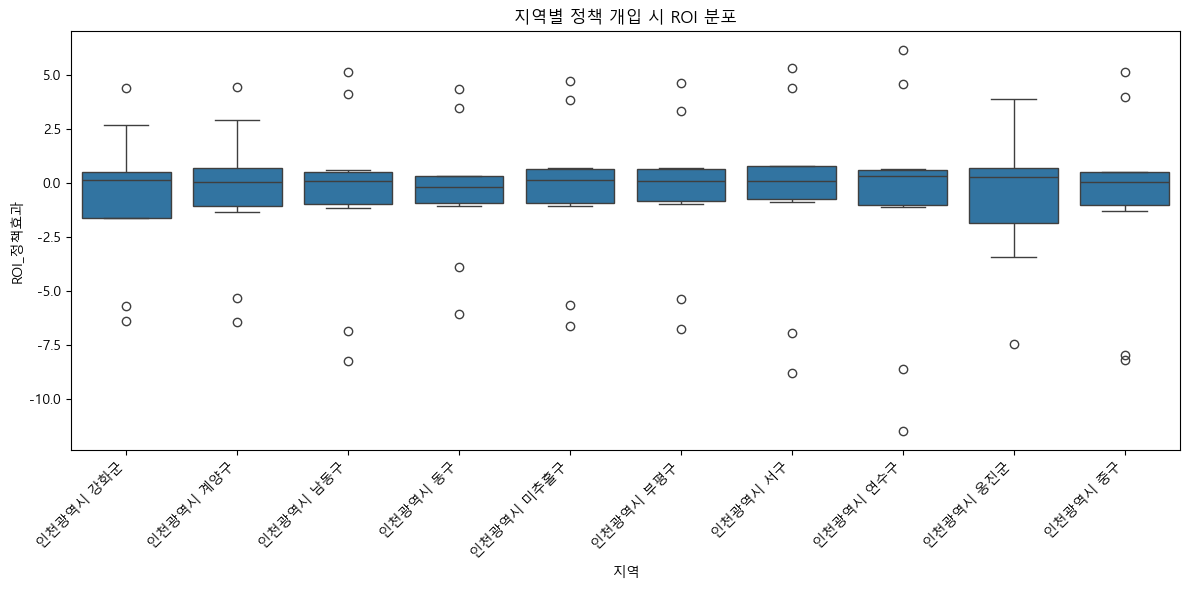

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

# 정책 개입 시점 데이터만 필터링
policy_data = final_df[final_df['정책_개입'] == True]

plt.figure(figsize=(12,6))
sns.boxplot(x='지역', y='ROI_정책효과', data=policy_data)
plt.xticks(rotation=45, ha='right')
plt.title('지역별 정책 개입 시 ROI 분포')
plt.ylabel('ROI_정책효과')
plt.tight_layout()
plt.show()


In [41]:
# 지역별 ROI_정책효과 통계 계산
region_sensitivity = final_df[final_df['정책_개입']].groupby('지역').agg(
    정책개입횟수=('정책_개입', 'sum'),
    정책효과평균=('ROI_정책효과', 'mean'),
    정책효과절대값평균=('ROI_정책효과', lambda x: x.abs().mean())
).reset_index()

# 민감도 평가 기준 추가 (절대값 기준)
def classify_sensitivity(value):
    if value >= 3:
        return '🔥 매우 민감'
    elif value >= 2.5:
        return '⚠️ 중간~높음'
    elif value >= 1:
        return '✅ 보통 수준'
    else:
        return '✅ 매우 둔감'

region_sensitivity['민감도'] = region_sensitivity['정책효과절대값평균'].apply(classify_sensitivity)

# 보기 좋게 정렬
region_sensitivity = region_sensitivity.sort_values(by='정책효과절대값평균', ascending=False)

# 결과 확인
print(region_sensitivity)


           지역  정책개입횟수    정책효과평균  정책효과절대값평균       민감도
7   인천광역시 연수구      11 -0.966120   3.444516   🔥 매우 민감
6    인천광역시 서구      11 -0.553159   2.889026  ⚠️ 중간~높음
9    인천광역시 중구      11 -0.755492   2.812558  ⚠️ 중간~높음
2   인천광역시 남동구      11 -0.634144   2.717262  ⚠️ 중간~높음
0   인천광역시 강화군      10 -0.668198   2.422233   ✅ 보통 수준
4  인천광역시 미추홀구      11 -0.391276   2.378611   ✅ 보통 수준
5   인천광역시 부평구      11 -0.439449   2.288108   ✅ 보통 수준
8   인천광역시 옹진군      10 -0.629938   2.287566   ✅ 보통 수준
1   인천광역시 계양구      11 -0.482531   2.235008   ✅ 보통 수준
3    인천광역시 동구      11 -0.360750   2.054692   ✅ 보통 수준


C:\Users\user\AppData\Local\Temp\ipykernel_29664\2551271259.py:22: UserWarning: Glyph 128293 (\N{FIRE}) missing from current font.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_29664\2551271259.py:22: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from current font.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_29664\2551271259.py:22: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from current font.
  plt.tight_layout()
C:\Users\user\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128293 (\N{FIRE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\user\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\user\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from current font.
  

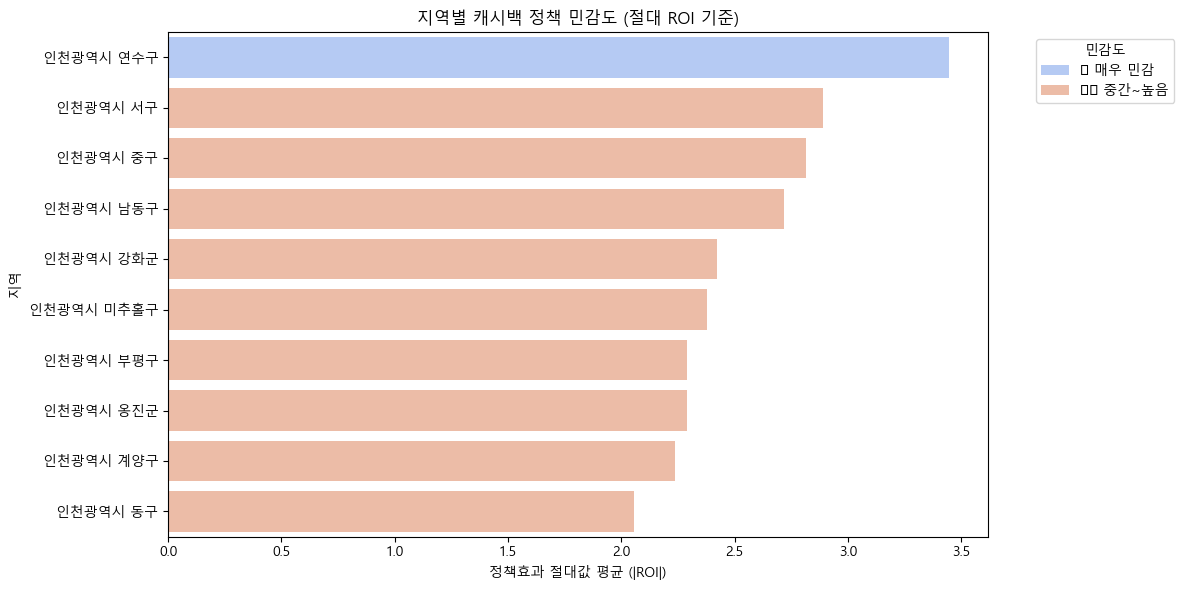

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

# 한글 폰트 설정 (윈도우 사용자용 예시: 'Malgun Gothic')
plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)

# 그래프 크기 및 스타일
plt.figure(figsize=(12, 6))
sns.barplot(
    data=region_sensitivity,
    x='정책효과절대값평균',
    y='지역',
    hue='민감도',
    dodge=False,
    palette='coolwarm'
)
plt.title('지역별 캐시백 정책 민감도 (절대 ROI 기준)')
plt.xlabel('정책효과 절대값 평균 (|ROI|)')
plt.ylabel('지역')
plt.legend(title='민감도', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [30]:
import pandas as pd
import numpy as np

# 데이터 불러오기
df = pd.read_csv("C:/Users/user/Desktop/졸업작품/인천e음_통합_일별.csv", encoding='utf-8', parse_dates=['일자'])

# 정책조합 함수 (연매출 3억 이하, 3억~30억 대상 비율 튜플로 반환)
def get_policy_status(row):
    return (row['연매출 3억원 이하'], row['연매출 3억~30억원'])

df['정책조합'] = df.apply(get_policy_status, axis=1)
df['연월'] = df['일자'].dt.to_period('M')
df['연도'] = df['일자'].dt.year

# 연도별 실제 집행액 (예산)
budget_dict = {
    2020: 214037000000,
    2021: 344411000000,
    2022: 304400000000,
    2023: 180991000000,
    2024: 129410000000,
}

budget_df = pd.DataFrame(list(budget_dict.items()), columns=['연도', '실제집행액'])
budget_df['월별투자비용'] = budget_df['실제집행액'] / 12

# 캐시백 비율 선택 함수 (target='low' or 'mid')
def get_cashback_ratio(row, target='low'):
    ratio_str = row['정책조합'][0] if target == 'low' else row['정책조합'][1]
    return float(ratio_str.replace('%', '')) / 100

# 결과 저장용 리스트
results = []

# 분석 대상: low = 3억 이하, mid = 3억~30억
target_group = 'mid'  # 'low'로 바꾸면 3억 이하 대상

for region, group in df.groupby('지역'):
    monthly_sum = group.groupby(['연월', '정책조합']).agg({'전체금액': 'sum'}).reset_index()
    monthly_sum['지역'] = region
    monthly_sum['연도'] = monthly_sum['연월'].dt.year

    # 주요 정책조합(비중 > 90%) 필터링
    total_by_month = group.groupby(['연월', '정책조합'])['전체금액'].sum().reset_index()
    total_by_month['월_총합'] = total_by_month.groupby('연월')['전체금액'].transform('sum')
    total_by_month['비중'] = total_by_month['전체금액'] / total_by_month['월_총합']
    dominant_df = total_by_month[total_by_month['비중'] > 0.9][['연월', '정책조합']]

    monthly_df = pd.merge(monthly_sum, dominant_df, on=['연월', '정책조합'])
    monthly_df.sort_values('연월', inplace=True)
    monthly_df['연월'] = monthly_df['연월'].astype(str)
    monthly_df['전월금액'] = monthly_df['전체금액'].shift(1)
    monthly_df['전월_정책조합'] = monthly_df['정책조합'].shift(1)

    monthly_df['정책_개입'] = (
        (monthly_df['정책조합'] != ('0%', '0%')) &
        ((monthly_df['전월_정책조합'] == ('0%', '0%')) |
         (monthly_df['정책조합'] != monthly_df['전월_정책조합']))
    )

    monthly_df = monthly_df.merge(budget_df[['연도', '월별투자비용']], on='연도', how='left')

    # 캐시백 비율 적용
    monthly_df['캐시백비율'] = monthly_df.apply(lambda row: get_cashback_ratio(row, target=target_group), axis=1)
    monthly_df['캐시백소진액'] = monthly_df['전체금액'] * monthly_df['캐시백비율']

    # ROI 계산
    monthly_df['매출증가액'] = monthly_df['전체금액'] - monthly_df['전월금액']
    monthly_df['ROI_전체'] = monthly_df['매출증가액'] / monthly_df['캐시백소진액']
    monthly_df['ROI_정책효과'] = monthly_df['ROI_전체'].where(monthly_df['정책_개입'])

    results.append(monthly_df)

final_df = pd.concat(results, ignore_index=True)

def show_region_data(region_name):
    #cols = ['지역', '연월', '정책조합', '전체금액', '전월금액', '캐시백비율', '캐시백소진액', '정책_개입', 'ROI_정책효과']
    cols = ['지역', '연월', '정책조합','ROI_전체', '정책_개입', 'ROI_정책효과']
    region_data = final_df[final_df['지역'] == region_name]
    return region_data[cols].reset_index(drop=True)

# 사용 예시: 인천광역시 중구 데이터 보기
result = show_region_data("인천광역시 옹진군")
print(result)


           지역       연월        정책조합    ROI_전체  정책_개입  ROI_정책효과
0   인천광역시 옹진군  2020-07  (10%, 10%)       NaN   True       NaN
1   인천광역시 옹진군  2020-08  (10%, 10%) -0.021738  False       NaN
2   인천광역시 옹진군  2020-09  (10%, 10%) -0.510013  False       NaN
3   인천광역시 옹진군  2020-10  (10%, 10%)  0.424708  False       NaN
4   인천광역시 옹진군  2020-11  (10%, 10%) -1.930833  False       NaN
5   인천광역시 옹진군  2020-12  (10%, 10%)  0.084238  False       NaN
6   인천광역시 옹진군  2021-01  (10%, 10%) -0.747331  False       NaN
7   인천광역시 옹진군  2021-02  (10%, 10%)  0.227860  False       NaN
8   인천광역시 옹진군  2021-03  (10%, 10%)  1.762317  False       NaN
9   인천광역시 옹진군  2021-04  (10%, 10%)  1.150608  False       NaN
10  인천광역시 옹진군  2021-05  (10%, 10%)  0.717222  False       NaN
11  인천광역시 옹진군  2021-06  (10%, 10%) -0.163234  False       NaN
12  인천광역시 옹진군  2021-07  (10%, 10%)  0.639785  False       NaN
13  인천광역시 옹진군  2021-08  (10%, 10%)  0.826780  False       NaN
14  인천광역시 옹진군  2021-09  (10%, 10%)  1.553395  False       NaN
15  인천광역

In [13]:
'''
import pandas as pd
import numpy as np

# 데이터 불러오기
df = pd.read_csv("C:/Users/user/Desktop/졸업작품/인천e음_통합_일별.csv", encoding='utf-8', parse_dates=['일자'])

# 캐시백 비율 구분: 매출 구간별 비율 조합으로 정책 상태 구분
def get_policy_status(row):
    return (row['연매출 3억원 이하'], row['연매출 3억~30억원'])

df['정책조합'] = df.apply(get_policy_status, axis=1)

# '일자'를 월 단위로 변환
df['연월'] = df['일자'].dt.to_period('M')

# 지역별, 월별, 정책조합별 전체금액 합계
monthly_sum = df.groupby(['지역', '연월', '정책조합'])['전체금액'].sum().reset_index()

# 지역별, 월별 전체금액 총합 구하기
monthly_sum['월_총합'] = monthly_sum.groupby(['지역', '연월'])['전체금액'].transform('sum')

# 월별, 지역별 정책조합별 비중 계산
monthly_sum['비중'] = monthly_sum['전체금액'] / monthly_sum['월_총합']

# 월별, 지역별 전체 소비액의 90% 이상 차지하는 조합 필터링
dominant_df = monthly_sum[monthly_sum['비중'] > 0.9][['지역', '연월', '정책조합']]

# 주요 조합만 필터링된 월별 데이터로 제한
monthly_df = monthly_sum[['지역', '연월', '정책조합', '전체금액']]
monthly_df = pd.merge(monthly_df, dominant_df, on=['지역', '연월', '정책조합'])

# 정렬 및 문자열 변환
monthly_df.sort_values(['지역', '연월'], inplace=True)
monthly_df['연월'] = monthly_df['연월'].astype(str)

# 전월 전체금액 및 전월 정책조합 추가 (지역 + 정책조합 기준으로 shift)
monthly_df['전월금액'] = monthly_df.groupby(['지역', '정책조합'])['전체금액'].shift(1)
monthly_df['전월_정책조합'] = monthly_df.groupby('지역')['정책조합'].shift(1)

# 정책 개입 여부 판단
monthly_df['정책_개입'] = (
    (monthly_df['정책조합'] != ('0%', '0%')) &
    ((monthly_df['전월_정책조합'] == ('0%', '0%')) |
     (monthly_df['정책조합'] != monthly_df['전월_정책조합']))
)

# ROI 계산 (전월금액 0 또는 NaN 방지)
monthly_df['ROI'] = np.where(
    monthly_df['전월금액'] > 0,
    (monthly_df['전체금액'] - monthly_df['전월금액']) / monthly_df['전월금액'],
    np.nan
)

monthly_df['ROI_정책효과'] = monthly_df['ROI'].where(monthly_df['정책_개입'])

# 지역별로 결과를 담을 딕셔너리 생성
result_by_region = {}

# 지역 리스트
regions = monthly_df['지역'].unique()

for region in regions:
    region_df = monthly_df[monthly_df['지역'] == region].copy()
    result_by_region[region] = region_df[['지역', '연월', '정책조합', '전체금액', '전월금액', '정책_개입', 'ROI_정책효과']]

# 예시 출력 — 인천 지역 결과
print(result_by_region['인천광역시 중구'])
'''

           지역       연월        정책조합         전체금액          전월금액  정책_개입  ROI_정책효과
504  인천광역시 중구  2020-07  (10%, 10%)  14936716072           NaN   True       NaN
505  인천광역시 중구  2020-08  (10%, 10%)  14524378842  1.493672e+10  False       NaN
506  인천광역시 중구  2020-09  (10%, 10%)  15354061466  1.452438e+10  False       NaN
507  인천광역시 중구  2020-10  (10%, 10%)  16024277503  1.535406e+10  False       NaN
508  인천광역시 중구  2020-11  (10%, 10%)  14670552467  1.602428e+10  False       NaN
509  인천광역시 중구  2020-12  (10%, 10%)  14644416715  1.467055e+10  False       NaN
510  인천광역시 중구  2021-01  (10%, 10%)  15154799886  1.464442e+10  False       NaN
511  인천광역시 중구  2021-02  (10%, 10%)  15717689457  1.515480e+10  False       NaN
512  인천광역시 중구  2021-03  (10%, 10%)  17421841044  1.571769e+10  False       NaN
513  인천광역시 중구  2021-04  (10%, 10%)  18155895077  1.742184e+10  False       NaN
514  인천광역시 중구  2021-05  (10%, 10%)  19150824381  1.815590e+10  False       NaN
515  인천광역시 중구  2021-06  (10%, 10%)  18636230223  1.9

In [16]:
'''
import pandas as pd
import numpy as np

# 데이터 불러오기
df = pd.read_csv("C:/Users/user/Desktop/졸업작품/인천e음_통합_일별.csv", encoding='utf-8', parse_dates=['일자'])

# 캐시백 비율 구분: 매출 구간별 비율을 조합해서 정책 상태 구분
def get_policy_status(row):
    return (row['연매출 3억원 이하'], row['연매출 3억~30억원'])

df['정책조합'] = df.apply(get_policy_status, axis=1)
df['연월'] = df['일자'].dt.to_period('M')
df['연도'] = df['일자'].dt.year

# 연도별 실제 집행액 (예산 반영용)
budget_dict = {
    2020: 214037000000,
    2021: 344411000000,
    2022: 304400000000,
    2023: 180991000000,
    2024: 129410000000,
}

# 예산 DataFrame 생성
budget_df = pd.DataFrame(list(budget_dict.items()), columns=['연도', '실제집행액'])
budget_df['월별투자비용'] = budget_df['실제집행액'] / 12

# 지역별로 반복 처리
results = []

for region, group in df.groupby('지역'):

    # 월별 전체금액 집계
    monthly_sum = group.groupby(['연월', '정책조합']).agg({
        '전체금액': 'sum'
    }).reset_index()
    monthly_sum['지역'] = region
    monthly_sum['연도'] = monthly_sum['연월'].dt.year

    # 월별 비중 계산 후 주요 정책조합 추출 (비중 > 90%)
    total_by_month = group.groupby(['연월', '정책조합'])['전체금액'].sum().reset_index()
    total_by_month['월_총합'] = total_by_month.groupby('연월')['전체금액'].transform('sum')
    total_by_month['비중'] = total_by_month['전체금액'] / total_by_month['월_총합']
    dominant_df = total_by_month[total_by_month['비중'] > 0.9][['연월', '정책조합']]

    # 주요 조합 필터링
    monthly_df = pd.merge(monthly_sum, dominant_df, on=['연월', '정책조합'])

    # 정렬 및 전월 정보 추가
    monthly_df.sort_values('연월', inplace=True)
    monthly_df['연월'] = monthly_df['연월'].astype(str)
    monthly_df['전월금액'] = monthly_df['전체금액'].shift(1)
    monthly_df['전월_정책조합'] = monthly_df['정책조합'].shift(1)
    monthly_df['정책_개입'] = (
        (monthly_df['정책조합'] != ('0%', '0%')) &
        ((monthly_df['전월_정책조합'] == ('0%', '0%')) |
         (monthly_df['정책조합'] != monthly_df['전월_정책조합']))
    )

    # 예산과 병합
    monthly_df = monthly_df.merge(budget_df[['연도', '월별투자비용']], on='연도', how='left')

    # ROI 계산 (예산 고려)
    monthly_df['매출증가액'] = monthly_df['전체금액'] - monthly_df['전월금액']
    monthly_df['ROI_예산기반'] = monthly_df['매출증가액'] / monthly_df['월별투자비용']
    monthly_df['ROI_정책효과'] = monthly_df['ROI_예산기반'].where(monthly_df['정책_개입'])

    results.append(monthly_df)

# 모든 지역 결과 병합
final_df = pd.concat(results, ignore_index=True)

def show_region_data(region_name):
    region_data = final_df[final_df['지역'] == region_name]
    display_cols = ['지역', '연월', '정책조합', '전체금액', '전월금액', '정책_개입', 'ROI_정책효과']
    return region_data[display_cols].reset_index(drop=True)

# 사용 예시:
# 인천광역시 중구만 보고 싶을 때
result = show_region_data("인천광역시 중구")
print(result)
'''

          지역       연월        정책조합         전체금액          전월금액  정책_개입  ROI_정책효과
0   인천광역시 중구  2020-07  (10%, 10%)  14936716072           NaN   True       NaN
1   인천광역시 중구  2020-08  (10%, 10%)  14524378842  1.493672e+10  False       NaN
2   인천광역시 중구  2020-09  (10%, 10%)  15354061466  1.452438e+10  False       NaN
3   인천광역시 중구  2020-10  (10%, 10%)  16024277503  1.535406e+10  False       NaN
4   인천광역시 중구  2020-11  (10%, 10%)  14670552467  1.602428e+10  False       NaN
5   인천광역시 중구  2020-12  (10%, 10%)  14644416715  1.467055e+10  False       NaN
6   인천광역시 중구  2021-01  (10%, 10%)  15154799886  1.464442e+10  False       NaN
7   인천광역시 중구  2021-02  (10%, 10%)  15717689457  1.515480e+10  False       NaN
8   인천광역시 중구  2021-03  (10%, 10%)  17421841044  1.571769e+10  False       NaN
9   인천광역시 중구  2021-04  (10%, 10%)  18155895077  1.742184e+10  False       NaN
10  인천광역시 중구  2021-05  (10%, 10%)  19150824381  1.815590e+10  False       NaN
11  인천광역시 중구  2021-06  (10%, 10%)  18636230223  1.915082e+10  Fa

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터 로딩
df = pd.read_csv("C:/Users/user/Desktop/졸업작품/인천e음_통합_일별.csv", encoding='utf-8')

In [3]:
import pandas as pd


# 캐시백률 문자열에서 % 제거 후 숫자로 변환
df['연매출 3억원 이하'] = df['연매출 3억원 이하'].str.replace('%','').astype(float)
df['연매출 3억~30억원'] = df['연매출 3억~30억원'].str.replace('%','').astype(float)
df['연매출 30억원 초과'] = df['연매출 30억원 초과'].str.replace('%','').astype(float)

# 분석 대상은 연매출 3억원 이하(캐시백 10%)와 3억~30억원(캐시백 5,7,10%) 구간
# 30억원 초과 구간은 제외하므로 필터링
df = df[df['연매출 30억원 초과'] == 0]


In [4]:
# 연매출 3억원 이하인 경우 캐시백 10% 고정
mask_low = df['연매출 3억원 이하'] == 10

# 연매출 3억~30억원 구간 캐시백률은 5,7,10 다양하게 있으니 그대로 둠
mask_mid = df['연매출 3억~30억원'].isin([5,7,10])

# 데이터 프레임 생성
df_low = df[mask_low].copy()
df_low['캐시백률'] = 10

df_mid = df[mask_mid].copy()
df_mid['캐시백률'] = df_mid['연매출 3억~30억원']

# 분석용 통합 데이터셋
df_analysis = pd.concat([df_low, df_mid])


In [5]:
# 캐시백률별 총 소비금액 합계, 평균 결제 건수
summary = df_analysis.groupby('캐시백률').agg({
    '전체금액': 'sum',
    '결제건수': 'mean',
    '충전건수': 'mean'
}).reset_index()

print(summary)


   캐시백률           전체금액           결제건수           충전건수
0   5.0  2470991061807  727238.021157  180708.462974
1   7.0  1094709974616  749051.020408  184732.653061
2  10.0  3619835393813  608026.166902  150785.007072


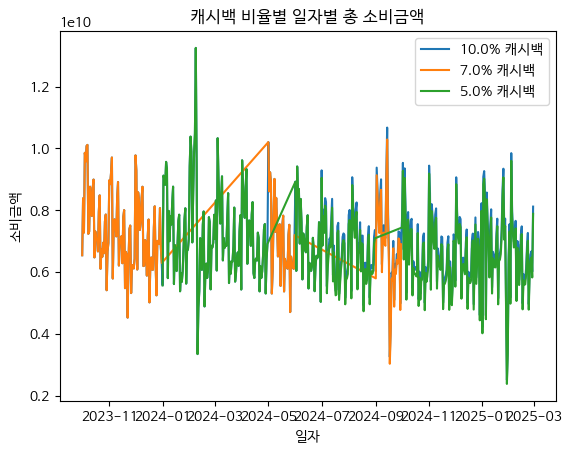

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib
import seaborn as sns

# 폰트 설정 (윈도우 기준)
font_location = 'C:\\Windows\\Fonts\\Hancom Gothic Regular.ttf'
font_name = fm.FontProperties(fname=font_location).get_name()
matplotlib.rc('font', family=font_name)
df_analysis['일자'] = pd.to_datetime(df_analysis['일자'])

for rate in df_analysis['캐시백률'].unique():
    subset = df_analysis[df_analysis['캐시백률'] == rate]
    plt.plot(subset.groupby('일자')['전체금액'].sum(), label=f'{rate}% 캐시백')

plt.title('캐시백 비율별 일자별 총 소비금액')
plt.xlabel('일자')
plt.ylabel('소비금액')
plt.legend()
plt.show()


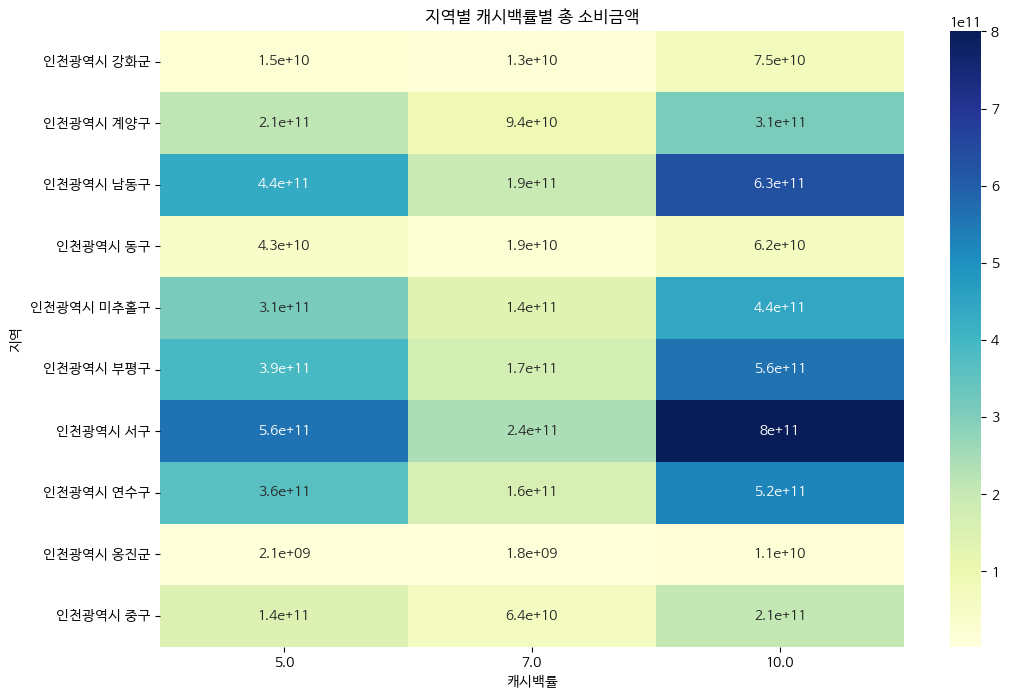

In [10]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib
import seaborn as sns

# 폰트 설정 (윈도우 기준)
font_location = 'C:\\Windows\\Fonts\\Hancom Gothic Regular.ttf'
font_name = fm.FontProperties(fname=font_location).get_name()
matplotlib.rc('font', family=font_name)

pivot = df_analysis.pivot_table(index='지역', columns='캐시백률', values='전체금액', aggfunc='sum').fillna(0)

plt.figure(figsize=(12,8))
sns.heatmap(pivot, annot=True, cmap='YlGnBu')
plt.title('지역별 캐시백률별 총 소비금액')
plt.show()


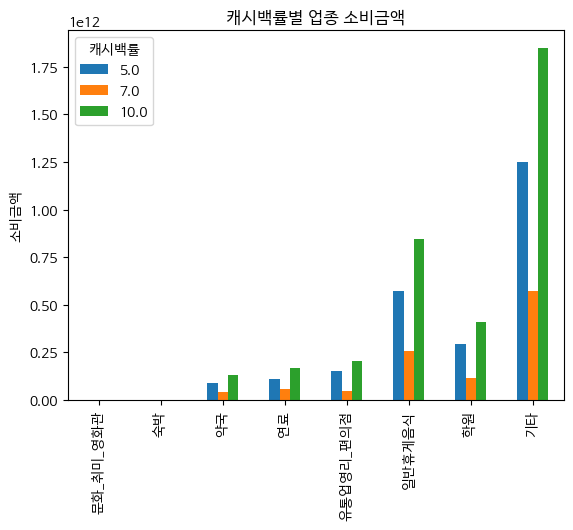

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib
import seaborn as sns

# 폰트 설정 (윈도우 기준)
font_location = 'C:\\Windows\\Fonts\\Hancom Gothic Regular.ttf'
font_name = fm.FontProperties(fname=font_location).get_name()
matplotlib.rc('font', family=font_name)
industry_cols = ['문화_취미_영화관', '숙박', '약국', '연료', '유통업영리_편의점', '일반휴게음식', '학원', '기타']

industry_sum = df_analysis.groupby('캐시백률')[industry_cols].sum()

industry_sum.T.plot(kind='bar')
plt.title('캐시백률별 업종 소비금액')
plt.ylabel('소비금액')
plt.show()


          캐시백률      전체금액      결제건수      충전건수
캐시백률  1.000000 -0.113471 -0.071120 -0.070306
전체금액 -0.113471  1.000000  0.730154  0.724867
결제건수 -0.071120  0.730154  1.000000  0.998810
충전건수 -0.070306  0.724867  0.998810  1.000000


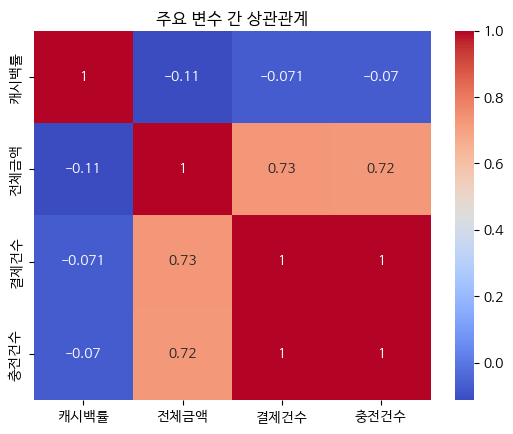

In [16]:
corr_cols = ['캐시백률', '전체금액', '결제건수', '충전건수']
corr = df_analysis[corr_cols].corr()
print(corr)

sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('주요 변수 간 상관관계')
plt.show()


In [14]:
# 3-1. 캐시백 0% 구간 데이터 만들기 (기준선)
df_zero = df[(df['연매출 3억원 이하'] == 0) & (df['연매출 3억~30억원'] == 0)]
baseline = df_zero['전체금액'].mean()

# 3-2. 캐시백별 평균 소비금액 계산
mean_consumption = df_analysis.groupby('캐시백률')['전체금액'].mean()

# 3-3. ROI 계산
roi_results = {}

for rate, avg_cons in mean_consumption.items():
    cashback_paid = avg_cons * (rate / 100)
    increase = avg_cons - baseline  # 소비 증가분
    roi = ((increase - cashback_paid) / cashback_paid) * 100 if cashback_paid > 0 else 0
    roi_results[rate] = roi

print("캐시백률별 ROI (%)")
for rate, roi in roi_results.items():
    print(f"{rate}% 캐시백: {roi:.2f}%")


캐시백률별 ROI (%)
5.0% 캐시백: nan%
7.0% 캐시백: nan%
10.0% 캐시백: nan%


In [13]:
from sklearn.linear_model import LinearRegression
import numpy as np

# 독립변수 X, 종속변수 y 설정
X = df_analysis[['캐시백률']]
y = df_analysis['전체금액']

# 회귀모델 생성 및 학습
model = LinearRegression()
model.fit(X, y)

print(f'회귀계수: {model.coef_[0]}')
print(f'절편: {model.intercept_}')
print(f'결정계수(R^2): {model.score(X, y)}')


회귀계수: -26539046.939432357
절편: 907751857.1038425
결정계수(R^2): 0.012875744307848325
